In [26]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
cluster <- makeCluster(16)  
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/3m_comparison.R')
source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

# 3 Methods Comparison Under Proportional Hazard

### 2 stages Rejection region of overall:
### 1. Log rank test
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1\ \&\ \frac{W}{\sigma}>m_2}$
### 2. Simple RMST Difference
#### $ \textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_2)-C(\tau_2)>m_2 }$
### 3. Our RMST Rejection method
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2}$
--------

#### <span style="color:yellow"> Setting in Jung's 2017 table 1 first row:
#### We set the total accrual time = 2 years and follow up 1 year
#### Recruit rate is 60(30 per arm) per year calculate the test power of 3 method controling $\alpha = 0.05$
#### <span style="color:yellow">We can only compare Minimax design since the default rule is searching for maximum stage I power


-----

# Differnent scenario 
#### <font color=yellow>Remarks: function 3m_comparison contains cocurrent foreach loop. 


## 1.  Different Hazard Ratio
### $\lambda_E = 0.83 = log(2)*12/10$. Median event time is around 10 months

In [3]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
lambda_H1 <- 0.83
alpha <- 0.05

diff_delta <- foreach(delta = seq(1.2, 2, by = 0.1), .combine = rbind)%dopar%
    {
        lambda_H0 <- lambda_H1 * delta
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', alpha = alpha)
                
        c(delta, result$alpha, result$power, result$PET0, result$PET1)      
    }

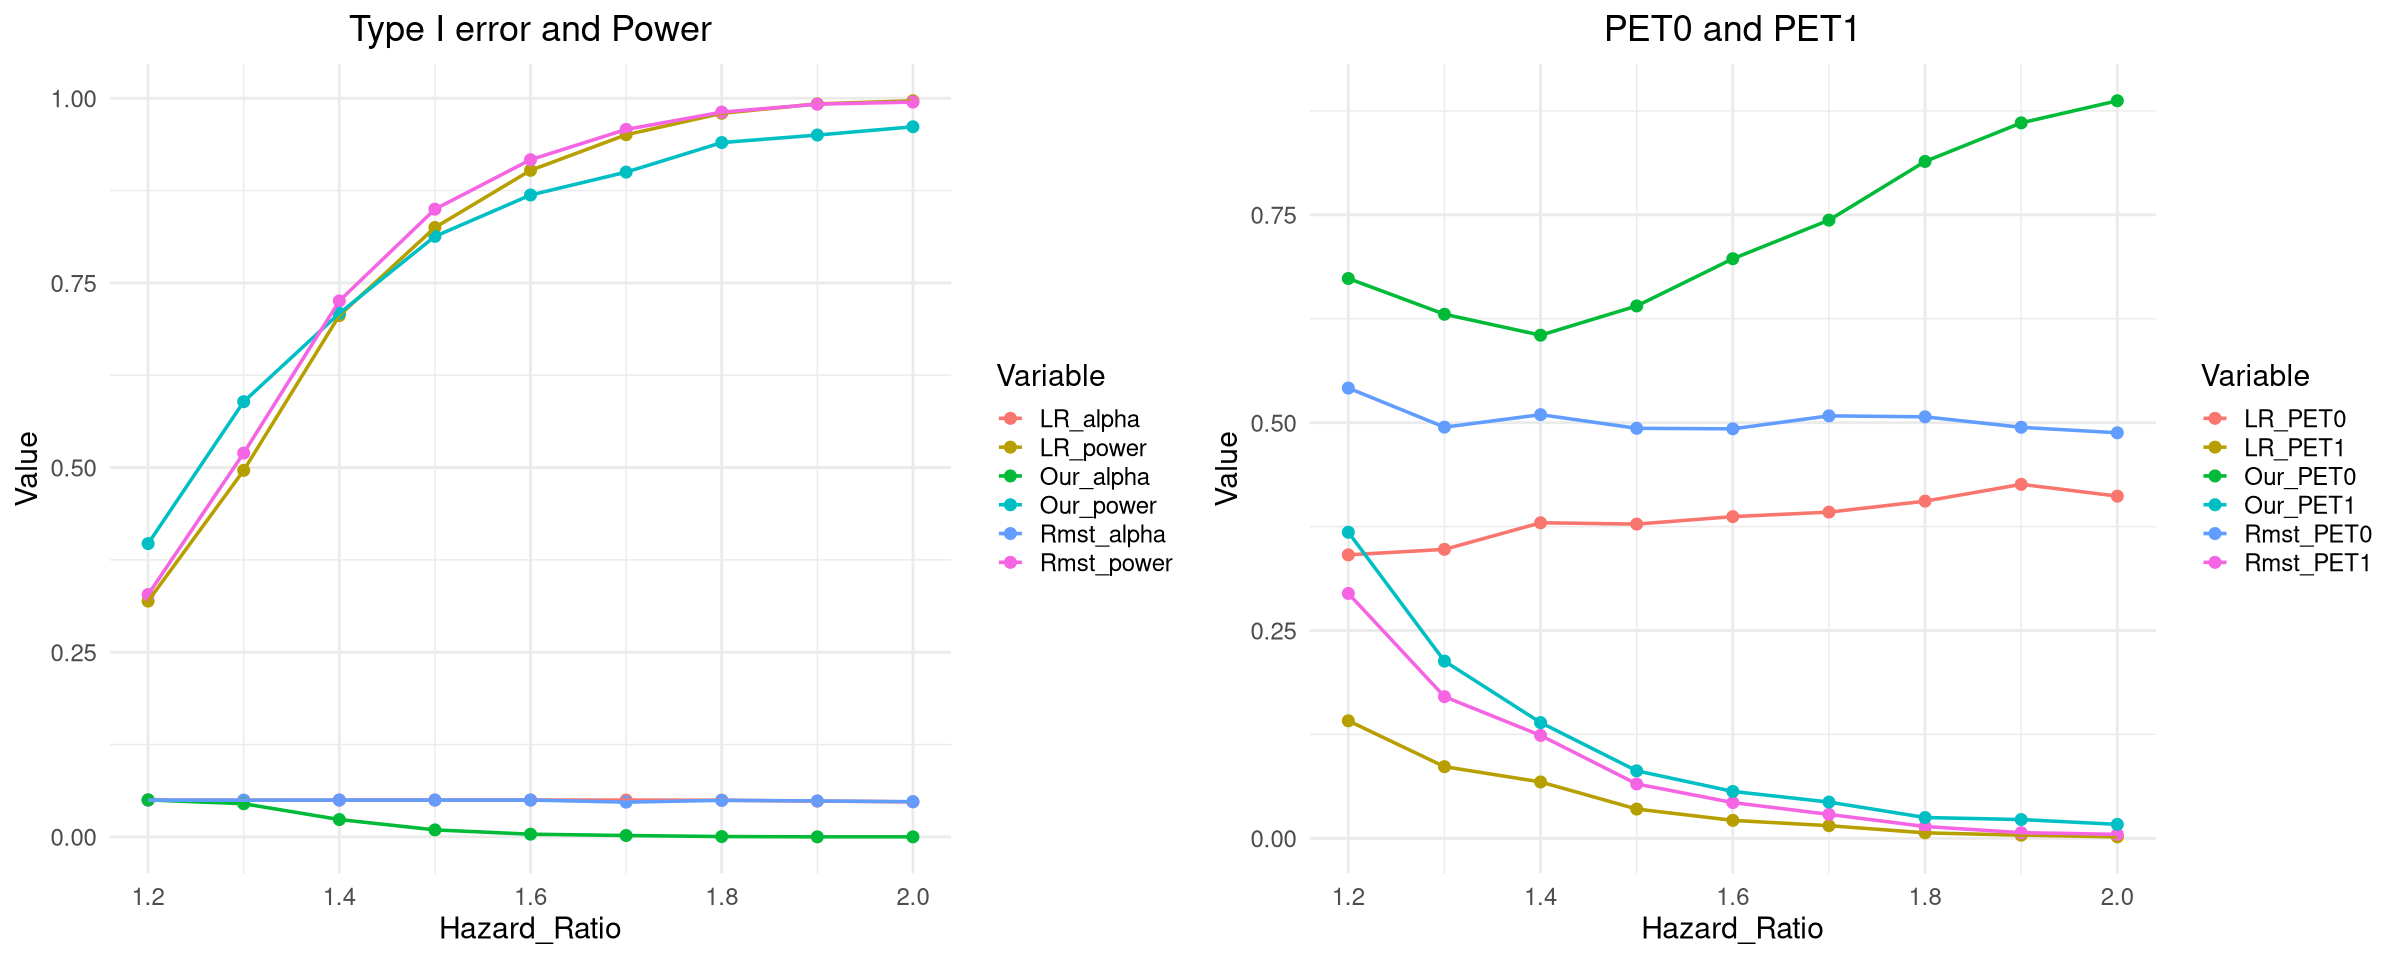

In [28]:
save(diff_delta, file = '/home/r27user6/RMST_Code/RData/diff_delta.RData')
load('/home/r27user6/RMST_Code/RData/diff_delta.RData')
# self-define function for drawing plots
compare_line_plot(data = diff_delta, var_name = 'Hazard_Ratio')

-----
## 2. Different interim period
### Interim period from 40% to 90% of the whole accrual period

In [29]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
alpha <- 0.05

diff_interim <- foreach(int_sam = seq(80, 180, by = 10), .combine = rbind) %do%
    {
        interim <- int_sam / r
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', alpha = alpha)
        c(interim, result$alpha, result$power, result$PET0, result$PET1)  
      
    }

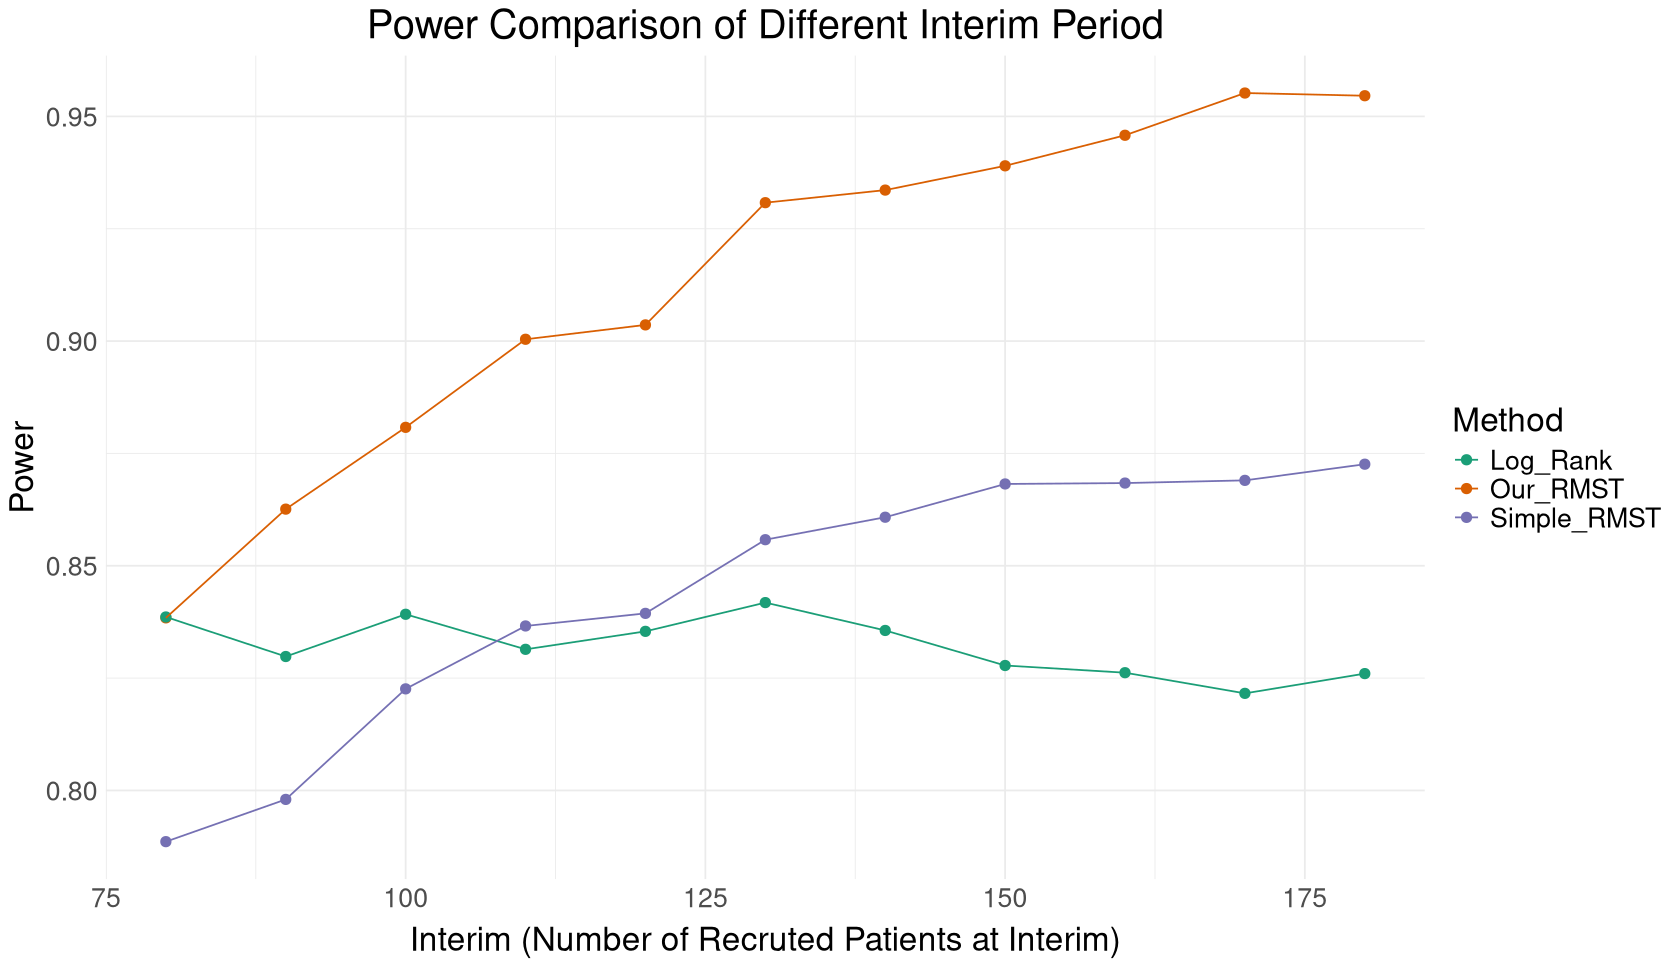

In [6]:
save(diff_interim, file = '/home/r27user6/RMST_Code/RData/diff_interim.RData')
load('/home/r27user6/RMST_Code/RData/diff_interim.RData')

compare_line_plot(data = diff_delta, var_name = 'Sample Size of Interim Period')

------
## 3. Different Recruit Rate
### Constant recruit rate. Smaller value means longer accrual time and interim period

In [7]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
cen_time <- 1
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
#grid search para__________
search_times <- 500
tar_a1 <- 0.8      #Upper bound of 1-PET0
tar_pow1_low <- 0  # lower bound of 1-PET1
tar_alpha <- 0.05

diff_rec_rate <- foreach(r = seq(40, 130, by = 10), .combine = rbind) %do%
    {
        acc_time <- 200 / r
        interim <- 120 / r 
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', alpha = alpha)
        c(r, result$alpha, result$power, result$PET0, result$PET1)      
    }

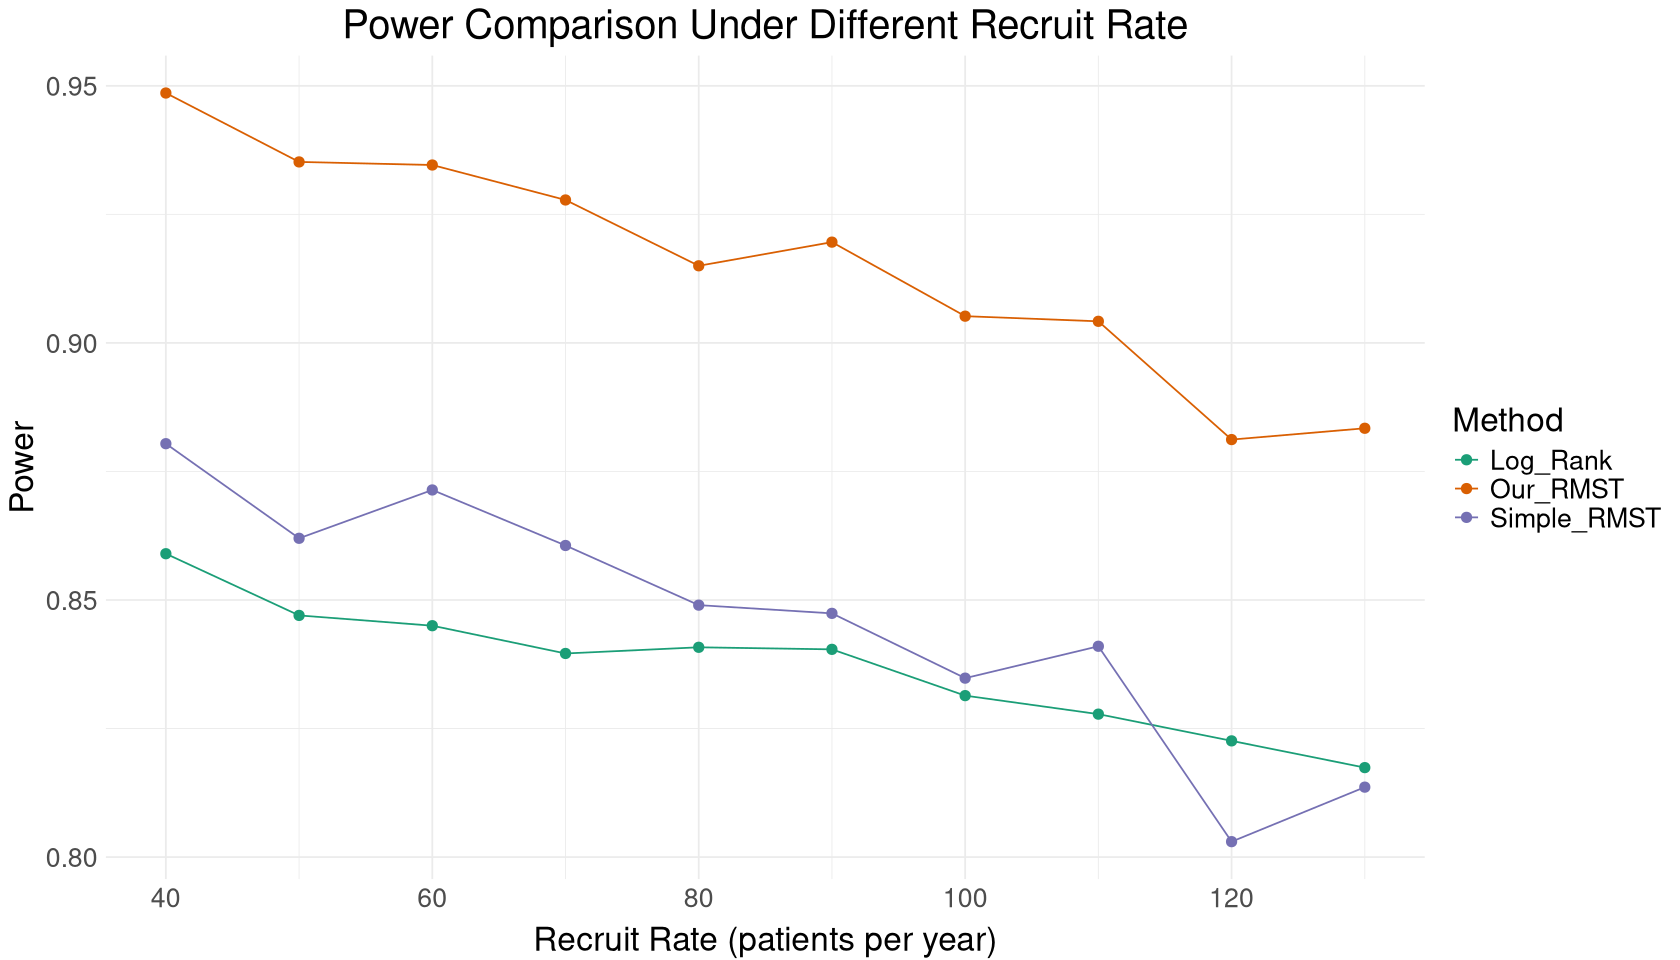

In [8]:
save(diff_rec_rate, file = '/home/r27user6/RMST_Code/RData/diff_rec_rate.RData')
load('/home/r27user6/RMST_Code/RData/diff_rec_rate.RData')

compare_line_plot(data = diff_rec_rate, var_name = 'Recruit_Rate')

------
## 4. Different $\lambda_E$
### Fix the hazard ratio, try different $\lambda$ of experiment group

In [12]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 60
acc_time <- 200 / r
interim <- 120 / r
cen_time <- 1
delta <- 1.5
#grid search para__________
search_times <- 500
tar_a1 <- 0.65      #Upper bound of 1-PET0
tar_pow1_low <- 0  # lower bound of 1-PET1
tar_alpha <- 0.05

diff_lamb_e <- foreach(lambda_H1 = seq(0.5, 1, by = 0.05), .combine = rbind) %do%
    {
        lambda_H0 <- lambda_H1 * delta
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', alpha = alpha)
        c(lambda_H1, result$alpha, result$power, result$PET0, result$PET1)        
    }

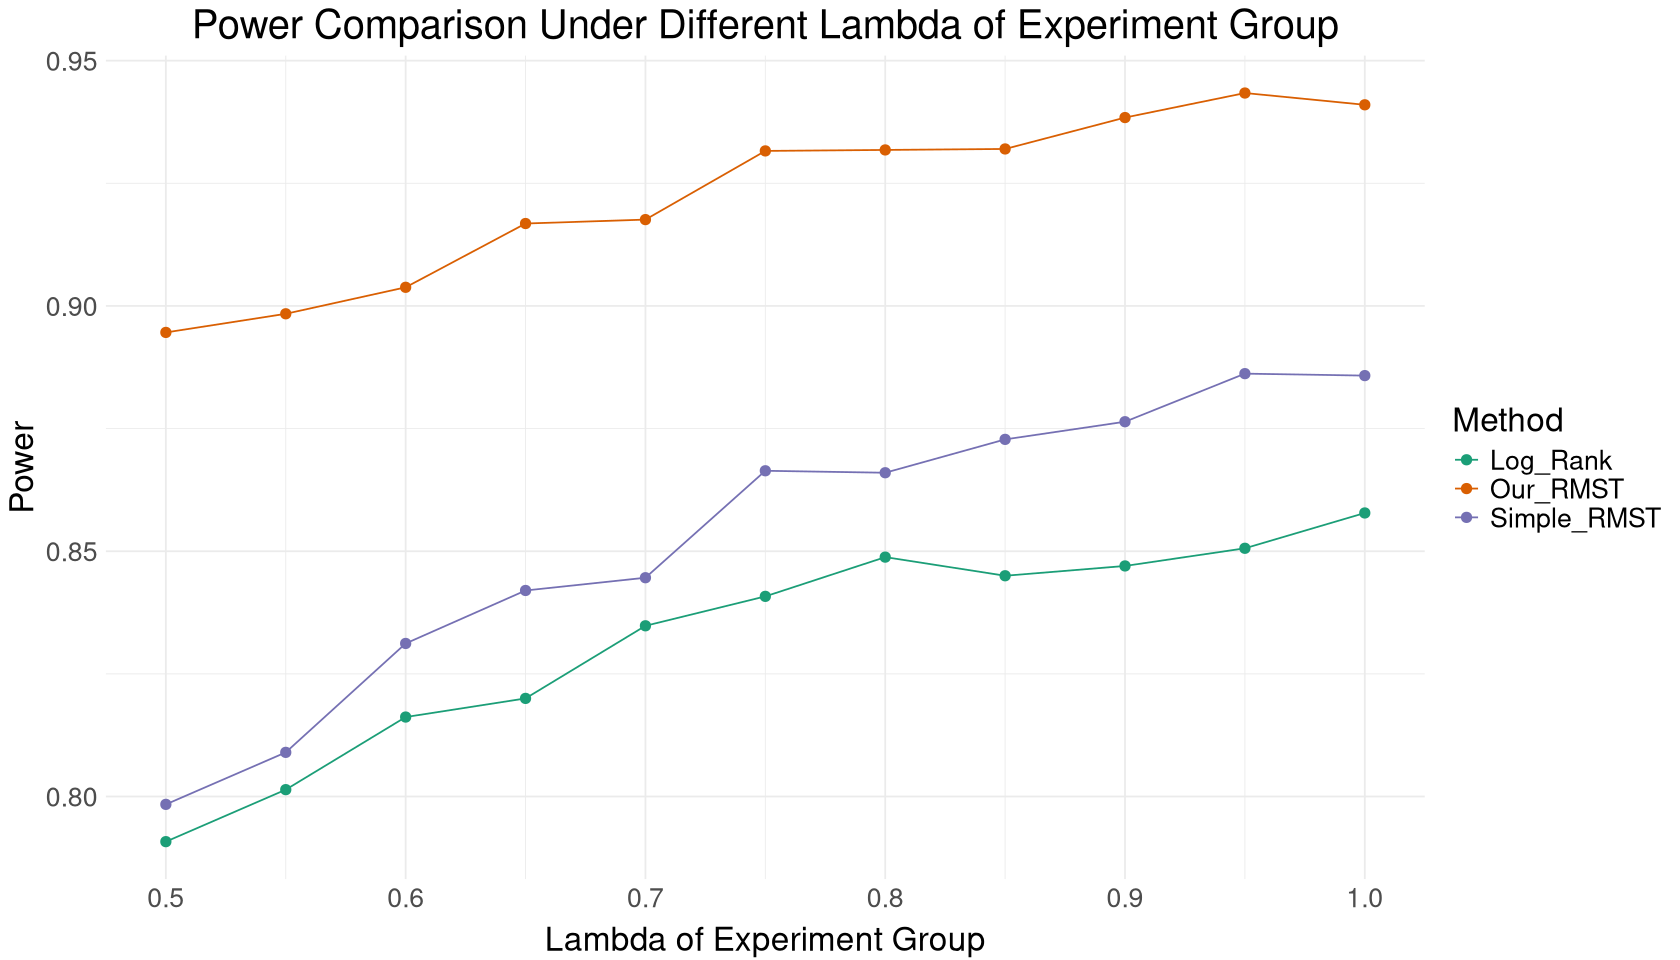

In [13]:
save(diff_lamb_e, file = '/home/r27user6/RMST_Code/RData/diff_lamb_e.RData')
load('/home/r27user6/RMST_Code/RData/diff_lamb_e.RData')

compare_line_plot(data = diff_lamb_e, var_name = 'Lambda_Experiment')

-----
## 5. Different Follow Up Time : censoring distribution
### Censoring distribution $C \sim U [b , a + b]$, where b is the follow up time.
### We tune b from 0.6 to 1.6

In [14]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 60
acc_time <- 200 / r
interim <- 120 / r
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
#grid search para__________
search_times <- 500
tar_a1 <- 0.65      #Upper bound of 1-PET0
tar_pow1_low <- 0  # lower bound of 1-PET1
tar_alpha <- 0.05

diff_cen <- foreach(cen_time = seq(0.6, 1.6, by = 0.1), .combine = rbind) %do%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', alpha = alpha)
        c(cen_time, result$alpha, result$power, result$PET0, result$PET1)       
    }

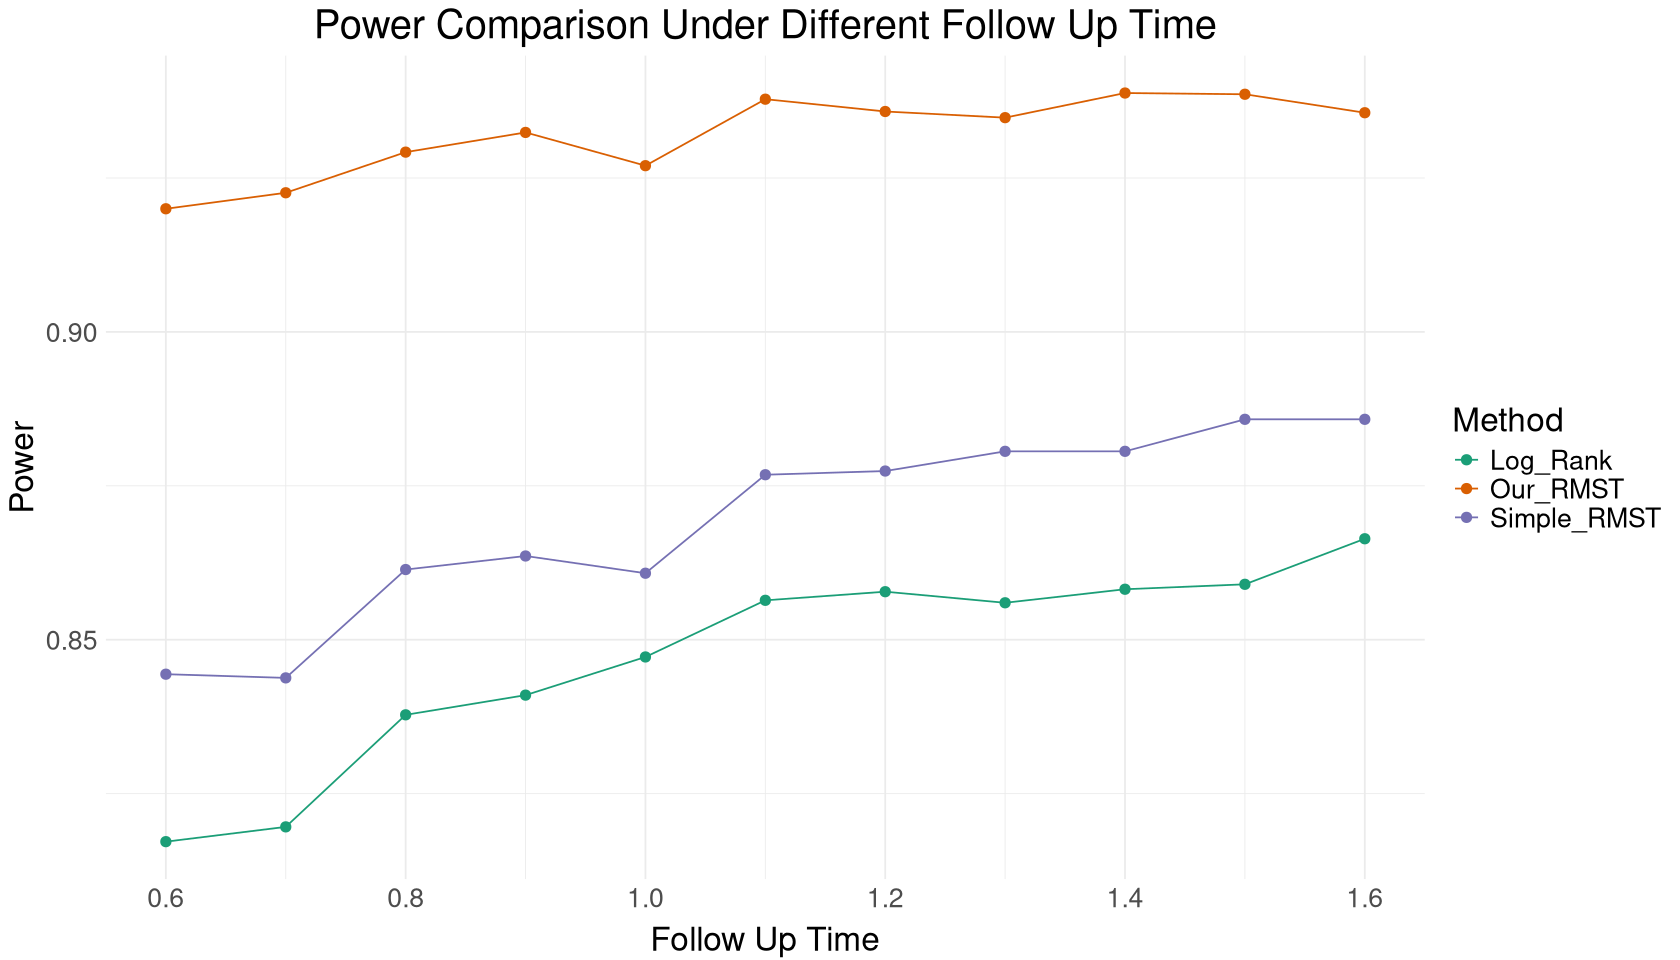

In [15]:
save(diff_cen, file = '/home/r27user6/RMST_Code/RData/diff_cen.RData')
load('/home/r27user6/RMST_Code/RData/diff_cen.RData')

compare_line_plot(data = diff_cen, var_name = 'Censoring_time')

-----
# Optimal design search 